In [2]:
import numpy as np
import pandas as pd
import os, sys, re, ast, csv, math, gc, random, enum, argparse, json, requests, time  
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None) # to ensure console display all columns
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_row', 40)
plt.style.use('ggplot')
from pathlib import Path
import joblib
from joblib import dump, load
from copy import deepcopy


dataPath = Path(r'/run/media/yen/MLData/MLProjects/UW_Insurance_Churn_Analysis/data')
pickleDataPath = dataPath / 'pickle'
dataInputPath = dataPath / 'input'
dataWorkingPath = dataPath / 'working'  


In [7]:
def fill_na_df(data_df, col_num, col_cat, na_val_num=0, na_val_cat='NA'):
    data_df[col_num] = data_df[col_num].fillna(na_val_num)
    data_df[col_cat] = data_df[col_cat].fillna(na_val_cat)    
    return data_df


def get_model_df(data_df, col_id, col_target, col_num, col_cat, feature_method, woe_map_dict=None):

    if feature_method == 'one_hot':
        col_init = [col_id, col_target] + col_num
        model_df = data_df[col_init].copy()
        for col in col_cat:
            model_df = pd.concat([model_df, pd.get_dummies(data_df[col], prefix=f"{col}--")], axis=1)    
        col_feature = [c for c in model_df.columns if c not in [col_id, col_target]]

    if feature_method == 'woe':
        col_init = [col_id, col_target] + col_num
        
        if woe_map_dict is None:
            model_df = data_df[col_init].copy()
            for col in col_cat:
                model_df = pd.concat([model_df, pd.get_dummies(data_df[col], prefix=f"{col}--")], axis=1)    
            
            col_bin = [c for c in model_df.columns if c not in col_init]
            data_df_bin = model_df[[col_id, col_target] + col_bin].copy()
            (_, woe_map_dict) = get_df_woe(data_df_bin, col_bin, col_target)
            
        
        data_df_cat = data_df[col_cat].copy()
        data_df_woe = map_woe_df(data_df_cat, woe_map_dict)
        model_df = pd.concat([data_df[col_init], data_df_woe], axis=1) 
        col_feature = [c for c in model_df.columns if c not in [col_id, col_target]]

    return (model_df, col_feature, woe_map_dict)


def get_df_woe(data_df_bin, col_bin, col_target):
    df_woe = pd.DataFrame(columns = ['feature_bin'], data = col_bin)        
    df_woe['feature'] = df_woe['feature_bin'].apply(lambda s: '_'.join(s.split('--_')[:-1]))    
    df_woe['dist_good'] = 0
    df_woe['dist_bad'] = 0    
    
    for feature in sorted(list(set(df_woe['feature']))):
        
        idx = df_woe['feature']==feature
        feature_bin_list = list(df_woe.loc[idx,'feature_bin'])
        df_woe.loc[idx,'dist_good'] = np.sum(np.array(data_df_bin[feature_bin_list])*(np.tile(np.array(data_df_bin[col_target]), (len(feature_bin_list),1)).T==0),axis=0)/np.sum(data_df_bin[col_target]==0)
        df_woe.loc[idx,'dist_bad'] = np.sum(np.array(data_df_bin[feature_bin_list])*(np.tile(np.array(data_df_bin[col_target]), (len(feature_bin_list),1)).T!=0),axis=0)/np.sum(data_df_bin[col_target]!=0)
              
    df_woe['WOE'] = np.log(df_woe['dist_good']/df_woe['dist_bad'])*100
    df_woe.loc[np.abs(df_woe['WOE'])==np.inf, 'WOE'] = 0
    df_woe.loc[df_woe['WOE'].isna(), 'WOE'] = 0

    woe_map_dict = {}
    for feature in sorted(list(set(df_woe['feature']))):
        idx = df_woe['feature']==feature
        woe_map_dict[feature] = {}
        for (feature_bin, woe) in zip(df_woe.loc[idx,'feature_bin'], df_woe.loc[idx,'WOE']):
            woe_map_dict[feature][woe] = [feature_bin.split('--_')[-1]]

    return (df_woe, woe_map_dict)


def map_woe_df(data_df_cat, woe_map_dict):
    
    def map_func(s):
        out = 0.0
        for k in woe_map_dict[col]:
            if s in woe_map_dict[col][k]:
                out = k
                break        
        return out    

    data_df_woe = data_df_cat.copy()
    
    for col in woe_map_dict:
        data_df_woe[col] = data_df_woe[col].apply(lambda s: map_func(s))
        data_df_woe[col] = data_df_woe[col].astype(np.float64)
        
    return data_df_woe

In [8]:
train_date = '2016-06-30'
feature_method = 'woe'
col_cat = ['COMM_STYLE','CLAWBACK_STYLE','REGION','BENEFITCODE',
           'gender1','SMOKER1','gender2','SMOKER2','occ_class','JOINTLIFE',
           'BENESC','PRODCODE','prem_freq','product','rated']

col_num = ['initial_sum_assured','POLTERM','UWLDPERML1_MORT','UWLDPERML2_MORT','UWPERMILL1_MORT','UWPERMILL2_MORT','age_life1','age_life2','pol_tenure']
col_id = 'id'
col_target = 'target'


train_df = pd.read_csv(os.path.join(dataWorkingPath / f"model_data_{train_date}.csv"))
train_df = fill_na_df(train_df, col_num, col_cat)  
(train_df, col_feature, woe_map_dict) = get_model_df(train_df, col_id, col_target, col_num, col_cat, feature_method)


We analyze the correlation between features by applying weight of evidence (WoE) encoding to the categorical features. WoE is a simple form of target encoding that converts categorical features to numerical features, to allow for numerical type analysis such as correlation analysis.

It seems that: <br> 
    1. POLTERM is highly correlated with BENEFITCODE, PRODCODE <br>
    2. product is highly correlated with BENESC 

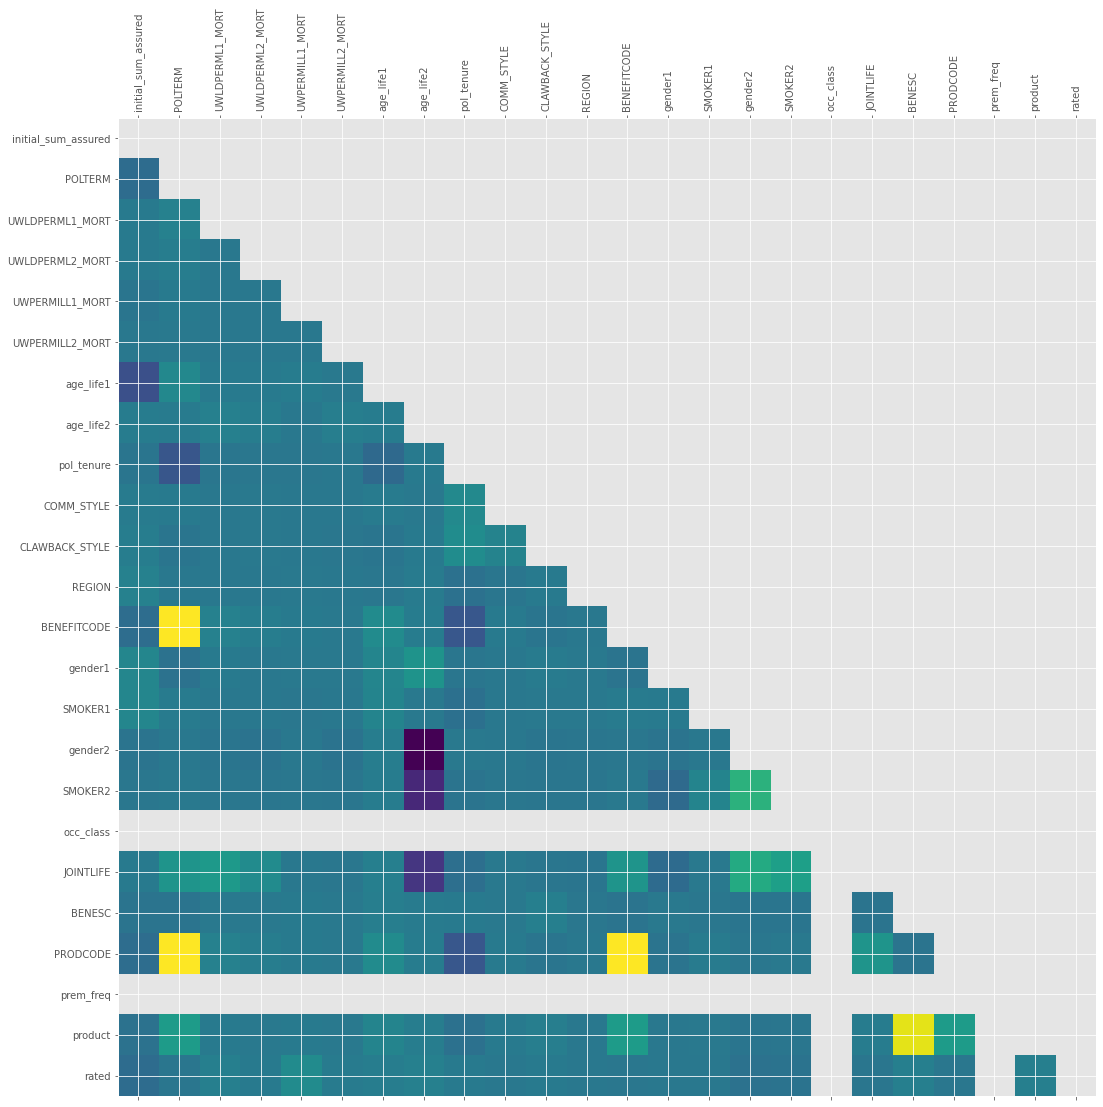

In [10]:
fig, ax = plt.subplots(figsize=(18, 18))
corr = train_df[col_feature].corr()
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))


xaxis = np.arange(len(col_feature))
caxes = ax.matshow(corr, interpolation ='nearest')
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(col_feature, rotation=90)
ax.set_yticklabels(col_feature)

plt.show()

As expected from the correlation analysis, POLTERM, BENEFITCODE, BENESC, PRODCODE, and product have a high variance inflation factor (VIF). The output dictionary shows the features with VIF > 10, as well as their corresponding VIF.

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    
col_feature_arr = np.array(col_feature)
col_idx = np.arange(len(col_feature_arr))
c = train_df[col_feature_arr[col_idx]].values
vif = np.array([variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])])
print({c: v for c, v in zip(col_feature_arr, vif) if v > 10})

{'POLTERM': 90.94083379619518, 'BENEFITCODE': 7542317.09393945, 'BENESC': 14.940058758785831, 'PRODCODE': 7537857.669556651, 'product': 15.915764493848464}


After removing BENEFITCODE, PRODCODE and BENESC from the feature set, we see that there are no longer any features with VIF > 10.

In [12]:
col_to_rm = ['BENEFITCODE','PRODCODE','BENESC']
col_feature = [c for  c in col_feature if c not in col_to_rm]
col_feature_arr = np.array(col_feature)
col_idx = np.arange(len(col_feature_arr))
c = train_df[col_feature_arr[col_idx]].values
vif = np.array([variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])])
print({c: v for c, v in zip(col_feature_arr, vif) if v > 10})

{}
